# Example long mean-field smlns for mean- vs fluc-driven sequences

## Dynamics

$$\alpha_d\left(\Theta^t\right) = 
\int_{x}\mathcal{N}\left(x; \mu_d, \sigma_d\right) \prod_{d'\neq d} \Phi\left(x; \mu_{d'}, \sigma_{d'}\right)$$

$$\mu_d = D \sum_{d'} \mu_J(d,d') \Theta_{d'}^t + u_d^t \quad \quad \sigma^2_d = D \sum_{d'} \sigma_J^2(d,d') \Theta_{d'}^t + v_d^t$$

Infinite networks

$$\Theta^{t+1} = \boldsymbol{\alpha}(\Theta^t)$$

Finite networks

$$N\Theta^{t+1} \sim \textrm{Multinomial}\left(\boldsymbol{\alpha}(\Theta^t), N\right)$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import sys

from aux import get_c_mean_p, get_c_spd
from disp import set_plot

In [2]:
# numeric params for computing MF quantities
DX = .01
X_MIN = -100
X_MAX = 100

X = np.linspace(X_MIN, X_MAX, int((X_MAX-X_MIN)/DX)+1)

def norm(x, mu, sgm):
    if sgm == 0:
        temp = np.zeros(X.shape)
        temp[np.argmin(np.abs(X))] = 1/DX
        return temp
    
    return stats.norm.pdf(x, loc=mu, scale=sgm)

def phi(x, mu, sgm):
    if sgm == 0:
        temp = (X >= 0).astype(float)
        temp[X == 0] = .5
        return temp
    
    return stats.norm.cdf(x, loc=mu, scale=sgm)

def alph(th, u, v, D, mu_j, sgm_j, N=np.inf):
    """
    th \in [0, 1]^D
    u \in R^D
    v \in R_+^D
    D scalar
    mu_j \in R^{DxD}
    sgm_j \in R^{DxD}
    """
    mu_d = D*(mu_j @ th) + u
    sgm_d = np.sqrt(D*((sgm_j**2)@th) + v)
    
    phis = np.array([phi(X, mu_d_, sgm_d_) for mu_d_, sgm_d_ in zip(mu_d, sgm_d)])
    
    mnot_d = ~np.eye(len(th), dtype=bool) # masks for selecting all but one d
    
    th_next = np.nan*np.zeros(D)
    for d, (mu_d_, sgm_d_) in enumerate(zip(mu_d, sgm_d)):
        
        mask_d = mnot_d[d]
        th_next[d] = min(np.sum(norm(X, mu_d_, sgm_d_) * np.prod(phis[mask_d, :], axis=0))*DX, 1)
        
    if np.isinf(N):
        return th_next
    else:
        return np.random.multinomial(N, th_next)/N

In [3]:
D = 16

mself = np.eye(D, dtype=bool)
mseq = np.diag(np.ones(D-1), -1).astype(bool)
mseq[0, -1] = True  # periodic

t_max = 2000
t = np.arange(t_max)

t_start = 200  # for speed estimation

In [4]:
A = np.arange(0, 2*np.pi, 2*np.pi/D)

# Mean-driven sequence network (starting from mean-self-coupled network)

In [5]:
MU_J_SELF = 3
MU_J_CROSS = 0
MU_J_SEQ = 2.3

SGM_J_SELF = 1
SGM_J_CROSS = 1
SGM_J_SEQ = 1

MU_J = np.nan*np.zeros((D, D))
SGM_J = np.nan*np.zeros((D, D))

MU_J[mself] = MU_J_SELF
MU_J[~mself] = MU_J_CROSS
MU_J[mseq] = MU_J_SEQ

SGM_J[mself] = SGM_J_SELF
SGM_J[~mself] = SGM_J_CROSS
SGM_J[mseq] = SGM_J_SEQ

th_0 = .05*np.random.rand(D)
th_0[:10] += 1
th_0 /= th_0.sum()

ths_md = np.nan*np.zeros((t_max, D))
ths_md[0, :] = th_0

for t_ in t[1:]:
    ths_md[t_, :] = alph(ths_md[t_-1, :], u=0, v=0, D=D, mu_j=MU_J, sgm_j=SGM_J)

In [6]:
# estimate speeds
c_mean_md = get_c_mean_p(A, ths_md)
spd_md = get_c_spd(c_mean_md, t_start)*D/(2*np.pi)

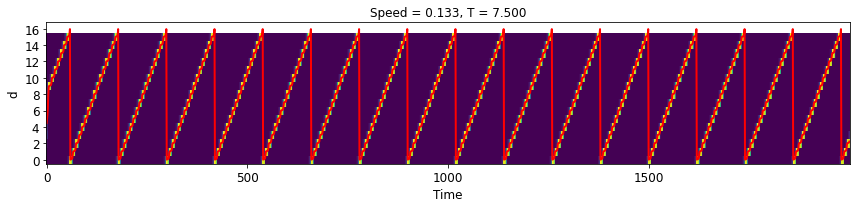

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3), tight_layout=True)

ax.matshow(ths_md.T, origin='lower')
ax.set_aspect('auto')
ax.plot((c_mean_md % (2*np.pi))*D/(2*np.pi), c='r', lw=2)

ax.xaxis.tick_bottom()
set_plot(ax, x_label='Time', y_label='d', title=f'Speed = {spd_md:.3f}, T = {1/spd_md:.3f}')

# Variance-driven sequence network (starting from variance self-coupled network)

In [8]:
MU_J_SELF = 0
MU_J_CROSS = 0
MU_J_SEQ = 0

SGM_J_SELF = 10
SGM_J_CROSS = 1
SGM_J_SEQ = 4.2

MU_J = np.nan*np.zeros((D, D))
SGM_J = np.nan*np.zeros((D, D))

MU_J[mself] = MU_J_SELF
MU_J[~mself] = MU_J_CROSS
MU_J[mseq] = MU_J_SEQ

SGM_J[mself] = SGM_J_SELF
SGM_J[~mself] = SGM_J_CROSS
SGM_J[mseq] = SGM_J_SEQ

th_0 = .05*np.random.rand(D)
th_0[:10] += 1
th_0 /= th_0.sum()

ths_fd = np.nan*np.zeros((t_max, D))
ths_fd[0, :] = th_0

for t_ in t[1:]:
    ths_fd[t_, :] = alph(ths_fd[t_-1, :], u=0, v=0, D=D, mu_j=MU_J, sgm_j=SGM_J)

In [9]:
# estimate speeds
c_mean_fd = get_c_mean_p(A, ths_fd)
spd_fd = get_c_spd(c_mean_fd, t_start)*D/(2*np.pi)

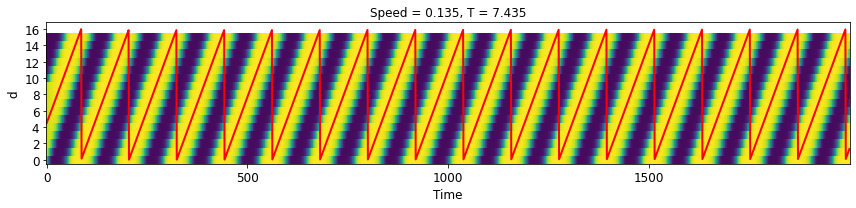

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3), tight_layout=True)

ax.matshow(ths_fd.T, origin='lower')
ax.set_aspect('auto')
ax.plot((c_mean_fd % (2*np.pi))*D/(2*np.pi), c='r', lw=2)

ax.xaxis.tick_bottom()
set_plot(ax, x_label='Time', y_label='d', title=f'Speed = {spd_fd:.3f}, T = {1/spd_fd:.3f}')

## Compare histograms of circular mean locations

In [11]:
# compute histogram window over integer number of periods
per_md = 1/spd_md*D
look_back_md = int(round(per_md * (int(np.floor(t_max/per_md)) - 1)))

per_fd = 1/spd_fd*D
look_back_fd = int(round(per_fd * (int(np.floor(t_max/per_fd)) - 1)))

print(f'Look back (mean-driven): {look_back_md}')
print(f'Look back (fluc-driven): {look_back_fd}')

Look back (mean-driven): 1800
Look back (fluc-driven): 1784


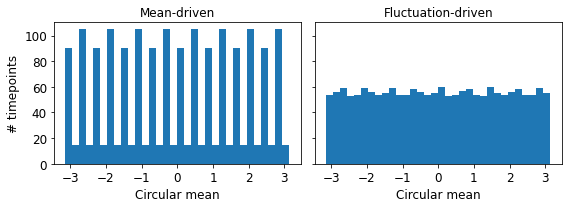

In [17]:
bins = np.linspace(-np.pi, np.pi, 2*D+1)
fig, axs = plt.subplots(1, 2, figsize=(8, 3), tight_layout=True, sharey=True)
axs[0].hist(c_mean_md[-look_back_md:], bins)
axs[0].set_ylabel('# timepoints')
axs[0].set_title('Mean-driven')

axs[1].hist(c_mean_fd[-look_back_fd:], bins)
axs[1].set_title('Fluctuation-driven')

for ax in axs:
    set_plot(ax, x_label='Circular mean')

In [13]:
np.save('data/seq_speed/seqs_long_mft.npy', np.array([{
    'D': D,
    
    'ths_md': ths_md,
    'c_mean_md': c_mean_md,
    'spd_md': spd_md,
    'look_back_md': look_back_md,
    
    'ths_fd': ths_fd,
    'c_mean_fd': c_mean_fd,
    'spd_fd': spd_fd,
    'look_back_fd': look_back_fd,
}]))